# DeepSets
## Permutation Invariant Neural Networks

This notebook is focused on DeepSets, a neural network architecture that takes into input sets rather than fixed dimensional vectors, and whose output should be invariant to permutation of this set. You will learn what is DeepSets, how it works, and implement yourself a DeepSets network that learns to compute the sum of any set of MNIST Digits, based on PyTorch. 
<br> 
<br>
This notebook is based on mainly two article : [Zaheer et al., 2017](https://arxiv.org/abs/1703.06114) which first introduced and applied the concept in 2017, and the response of [Wagstaff et al., 2019](https://arxiv.org/abs/1901.09006) on the limitations of this method of representing functions on sets. Both paper can be found in the /biblio repository. The code is inspired by [this Github repository](https://github.com/yassersouri/pytorch-deep-sets), by Yasser Souri.


<br>

#### First let's import a few modules while you read the intro. You might need to install tensorboardX, use pip ! (pip install tensorboardX)



In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import FloatTensor
from torch.utils.data.dataset import Dataset
from torchvision.datasets import MNIST
from torchvision.transforms import Compose, ToTensor, Normalize
from torch import optim
from torch.autograd import Variable

from tensorboardX import SummaryWriter

from typing import Tuple
from typing import Union
from tqdm import tqdm

RANDOM_SEED = 0
DATA_ROOT = './datasets/'
NetIO = Union[FloatTensor, Variable]
MNIST_TRANSFORM = Compose([ToTensor(), Normalize((0.1307,), (0.3081,))])

## 0 - Introduction

Most successful deep learning approaches make use of the *structure* in their inputs: CNNs are the state-of-the-art for images, RNNs and temporal convolutions for sequences, etc. The success of convolutional networks boils down to exploiting a key invariance property: translation invariance. 

But images and sequences are far from the only data we want to build neural networks for. Often our inputs are sets: sequences of items, where the ordering of items caries no information for the task in hand. In such a situation, the invariance property we can exploit is **permutation invariance**. Such problems are frequent, for instance parsing a scene composed of a set of objects ([Eslami et al., 2016](https://arxiv.org/abs/1603.08575)), making predictions from a set of points forming a 3D point cloud ([Qi et al., 2017](https://arxiv.org/abs/1612.00593)) or training a set of agents in reinforcement learning ([Sunehag et al., 2017](https://www.sciencedirect.com/science/article/pii/S240589631932035X)). In the original paper, the authors [Zaheer et al., 2017](https://arxiv.org/abs/1703.06114) applied it in cosmology by improving red-shift estimation and anomaly detection in celebrities faces databases ! The model showed both qualitative and quantitative results in every case.


**Note** : Another feature discussed in the original paper is *permutation equivariance* . However, since it is a relatively different concept from *invariance*, and do not apply in the same way, nor to the same goal, we will discuss it in the Appendix. 


## I - Permutation Invariance

Intuitively, permutation invariances states that the output of the model must not change if the inputs are reordered. For instance, this is what a permutation invariant function with three inputs would look like : $ f(a,b,c) = f(b,a,c) = f(b,c,a) = \cdots $. More mathematically speaking, the exact definition is the following:

<div class="alert alert-success" style="margin-top: 1em">
A function $f(\mathbf{x})$ is <i>permutation invariant</i> if $f(\{x_1, ... , x_M\}) = f(\{x_{\pi(1)}, ... , x_{\pi(M)}\})$ for any permutation $\pi$.
</div> 

Having this in my mind, how do we define permutation-invariant neural networks? Remember, we need to define a model that does not rely on the order of its inputs.

The main idea is to make use of some operation $P$ that is already permutation invariant. We map each of our inputs separately to another space, and apply to them our $P$ to obtain a representation of the set as a whole. $P$ destroys the ordering information, leaving the overall model permutation invariant.

In particular, <i>DeepSets</i> does this by setting $P$ to be summation on the latent space $Z$. Other operations are used as well, e.g. elementwise max. We call the case where the sum is used <i>sum-decomposition via the latent space</i> : 


<div class="alert alert-success" style="margin-top: 1em">
    A function $f$ is <i>sum-decomposable</i> if there are functions $\rho$ and $\phi$ such that : \[f(X) = \rho(\sum_{x \in X} \phi(x))\]
    In this case, we say that $(\rho,\phi)$ is a <i>sum-decomposition</i> of $f$. The codomain of $\phi$ (hence, the domain of $\rho$) is called the <i>latent space</i> $Z$.
</div>

We can now introduce the main backbone theorem for our work:

<div class="alert alert-success" style="margin-top: 1em">
    We denote by $\mathcal{P}(\mathfrak{X}) $ the power set of $\mathfrak{X}$, i.e the set of the sets of $\mathfrak{X}$.
    Let $f : \mathcal{P}(\mathfrak{X}) \rightarrow \mathbb{R}$ where $\mathfrak{X}$ is $\textbf{countable}$ (i.e, its cardinality is smaller or equal to the number of elements in $\mathbb{N}$. This includes both finite and countably infinite sets; e.g. $\mathbb{N}$, $\mathbb{Q}$, and subsets thereof). Then <b>$f$ is permutation-invariant if and only if it is sum-decomposable via the latent space $\mathbb{R}$</b>.
</div>

<div class="alert alert-danger"><a href="#answer3" data-toggle="collapse"><b>Proof; you may try to do it as an exercice! (click to expand)</b></a><br>
<div id="answer3" class="collapse">
    
Since $\mathfrak{X}$ is countable, each $x \in \mathfrak{X}$ can be mapped to a unique element in $\mathbb{N}$ by a function $c(x) : \mathfrak{X} \rightarrow \mathbb{N}$. Let $\Phi(X) = \sum_{􏰄x \in X} \phi(x)$. If we can choose $\phi$ so that $\Phi$ is injective, then we can set $\rho = f ◦ \Phi^{−1}$, giving \begin{equation} f = \rho ◦ \Phi = \rho(\sum_{x \in X} \phi(x)) \quad \text{i.e, $f$ is sum-decomposable via $\mathbb{R}$.}\end{equation} 
Now, consider $\phi(x) = 4^{-c(x)}$. Under this mapping, each $X \subset \mathfrak{X}$ corresponds to a unique real number expressed in base 4. Therefore $\Phi$ is injective, hence the theorem.
</div>
</div>

Great ! We now have a fully-functional theorem that states that if we can sum-decompose our network to $\mathbb{R}$, then it is permutation-invariant. The high-level description of the full architecture is now reasonably straightforward - transform your inputs into some latent space, destroy the ordering information in the latent space by applying the sum, and then transform from the latent space to the final output. This is illustrated in the following figure:

<img src="img/DeepSets_structure.png" width="600px"></img>

Replacing $\phi$ and $\rho$ by universal approximators leaves matters unchanged, since, in particular, $\phi$ and $\rho$ can be used to approximate arbitrary polynomials. Therefore, we can develop our own DeepSet network by learning these approximator!

## II - Implementation : MNIST digits sum
In this applied section, we want to build a network than learns to compute **any sum** of **any set** of MNIST Digits using DeepSets. 
Why not use a classic Neural Network and train it to add its inputs? Let's look at the following picture.
<br>
<img src="img/simpleNN.png" width="500px"></img>
<br>
Well this would certainly work for a fixed number N of digits. But remember, we want to be able to compute the sum of **any number M of digits** ! We would need to retrain the network on this new number of inputs, which isn't ideal... Would a recurrent network work then?
<br>
<img src="img/rNN.png" width="500px"></img>


It could work. However, we have **no guaranty** that the sum of digits will remain the same if you switch two or more digits. Which is why we will use DeepSets, which has this nice property !

First of, let's define a class that instantiates a set of MNIST and returns its correct sum based on the labels of the MNIST digits.

In [2]:
# This class instantiates a set of MNIST and returns its sum based on the label (targets) of the MNIST digits
# min_len : minimum length of the sets generated
# max_len : maximum length of the sets generated
# dataset_len : length of the dataset, ie. how many sets of MNIST digits there is

class MNISTSummation(Dataset):
    def __init__(self, min_len: int, max_len: int, dataset_len: int, train: bool = True, transform: Compose = None):
        self.min_len = min_len
        self.max_len = max_len
        self.dataset_len = dataset_len
        self.train = train
        self.transform = transform
        
        self.mnist = MNIST(DATA_ROOT, train=self.train, transform=self.transform, download=True)
        
        mnist_len = self.mnist.__len__()
        mnist_items_range = np.arange(0, mnist_len)

        items_len_range = np.arange(self.min_len, self.max_len + 1)
        items_len = np.random.choice(items_len_range, size=self.dataset_len, replace=True)
        self.mnist_items = []
        for i in range(self.dataset_len):
            self.mnist_items.append(np.random.choice(mnist_items_range, size=items_len[i], replace=True))

    def __len__(self) -> int:
        return self.dataset_len

    def __getitem__(self, item: int) -> Tuple[FloatTensor, FloatTensor]:
        mnist_items = self.mnist_items[item]

        the_sum = 0
        images = []
        for mi in mnist_items:
            img, target = self.mnist.__getitem__(mi)
            the_sum += target
            images.append(img)

        return torch.stack(images, dim=0), torch.FloatTensor([the_sum])

Let's test it for a batch of 5 sets, each having a length between 2 and 10. This is so we can visualize sets of digits of different length.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


-------------------------------------------------------
Correct sum of the MNIST digits  :  39.0


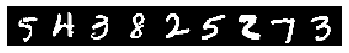

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


-------------------------------------------------------
Correct sum of the MNIST digits  :  16.0


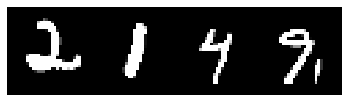

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


-------------------------------------------------------
Correct sum of the MNIST digits  :  16.0


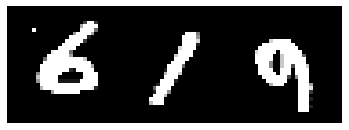

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


-------------------------------------------------------
Correct sum of the MNIST digits  :  29.0


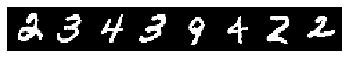

-------------------------------------------------------
Correct sum of the MNIST digits  :  39.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


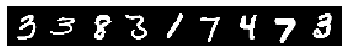

In [18]:
dataset_length = 5

MNISTSum = MNISTSummation(min_len=2, max_len=10, dataset_len=dataset_length, train=True, transform=MNIST_TRANSFORM)

for i in range(dataset_length):
    img = MNISTSum.__getitem__(i)
    print("-------------------------------------------------------")
    print("Correct sum of the MNIST digits  : ",img[1].item())
    plt.imshow(torchvision.utils.make_grid(img[0], nrow=10).permute(1, 2, 0), cmap='gray')
    plt.axis('off')
    plt.show()


It works! Great. Now let's define the $\phi$ and $\rho$ functions of our DeepSets model.

In [4]:
class SmallMNISTCNNPhi(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc1_drop = nn.Dropout2d()
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x: NetIO) -> NetIO:
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = self.conv2_drop(self.conv2(x))
        x = F.relu(F.max_pool2d(x, 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = self.fc1_drop(x)
        x = F.relu(self.fc2(x))
        return x


class SmallRho(nn.Module):
    def __init__(self, input_size: int, output_size: int = 1):
        super().__init__()

        self.input_size = input_size
        self.output_size = output_size

        self.fc1 = nn.Linear(self.input_size, 10)
        self.fc2 = nn.Linear(10, self.output_size)

    def forward(self, x: NetIO) -> NetIO:
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

We can now define our own DeepSets ! Your turn to work. Based on the figure in the first part, and the explanations, complete the DeepSets model.

In [5]:
### Complete the code below!
# If you get stuck, uncomment the line in the next cell to load a correction (then you can execute the code).

class InvariantModel(nn.Module):
    def __init__(self, phi: nn.Module, rho: nn.Module):
        super().__init__()
        self.phi = phi
        self.rho = rho

    def forward(self, x: NetIO) -> NetIO:
        
        # Complete here !
        
        return out

In [6]:
# True solution : uncomment and execute the line below
#%load solution/solution.py

Good job ! Now we can define our final model that will learn to sum up the digits.

In [7]:
# DeepSets Model that sums up the digits. For better performance, use a dataset_len >10000 for training and testing
# This allows the model to train better.

class SumOfDigits(object):
    def __init__(self, lr=1e-3, wd=5e-3): #learning rate, weight decay 
        self.lr = lr
        self.wd = wd
        
        self.train_db = MNISTSummation(min_len=2, max_len=30, dataset_len=2000, train=True, transform=MNIST_TRANSFORM)
        self.test_db = MNISTSummation(min_len=2, max_len=30, dataset_len=2000, train=False, transform=MNIST_TRANSFORM)

        self.the_phi = SmallMNISTCNNPhi()
        self.the_rho = SmallRho(input_size=10, output_size=1)

        self.model = InvariantModel(phi=self.the_phi, rho=self.the_rho)
        if torch.cuda.is_available():
            self.model.cuda()

        self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr, weight_decay=self.wd)

        self.summary_writer = SummaryWriter(
            log_dir='./logs/exp-lr:%1.5f-wd:%1.5f/' % (self.lr, self.wd))

        
    # Train a complete epoch
    def train_1_epoch(self, epoch_num: int = 0):
        self.model.train()
        for i in tqdm(range(len(self.train_db))): 
            loss = self.train_1_item(i)
            self.summary_writer.add_scalar('train_loss', loss, i + len(self.train_db) * epoch_num)

    # Train a single MNIST digit set
    def train_1_item(self, item_number: int) -> float:
        x, target = self.train_db.__getitem__(item_number)
        if torch.cuda.is_available():
            x, target = x.cuda(), target.cuda()

        x, target = Variable(x), Variable(target)

        self.optimizer.zero_grad()
        pred = self.model.forward(x)
        the_loss = F.mse_loss(pred, target)

        the_loss.backward()
        self.optimizer.step()

        the_loss_tensor = the_loss.data
        if torch.cuda.is_available():
            the_loss_tensor = the_loss_tensor.cpu()

        the_loss_numpy = the_loss_tensor.numpy().flatten()
        the_loss_float = float(the_loss_numpy[0])

        return the_loss_float

    # Evaluate the quality of prediction
    def evaluate(self):
        
        self.model.eval()
        
        totals = [0] * 51
        corrects = [0] * 51

        for i in tqdm(range(len(self.test_db))):
            
            x, target = self.test_db.__getitem__(i)
            
            item_size = x.shape[0]

            if torch.cuda.is_available():
                x = x.cuda()

            pred = self.model.forward(Variable(x)).data

            if torch.cuda.is_available():
                pred = pred.cpu().numpy().flatten()

            pred = int(round(float(pred[0])))
            target = int(round(float(target.numpy()[0])))

            totals[item_size] += 1

            if pred == target:
                corrects[item_size] += 1

        totals = np.array(totals)
        corrects = np.array(corrects)
    
        print("Totals: ",totals)
        print("Corrects: ",corrects)
        
        print(corrects / totals)
    
    # Simple function for you to test and visualize the model performance
    def test_after_training(self, x_test):
        pred_test = self.model.forward(Variable(x_test)).data
        pred_test = int(round(float(pred_test[0])))
        return pred_test

Now let's train our model. 
<br>
<br>
For better results, I recommend changing the dataset_len to 10000 (**at least**) in the previous class SumOfDigits, and train our model on 30-35 iterations below.
<br>
<br>
However **be careful, this might be REALLY heavy for your computer**. You might want to launch it on Google Colab or any other external GPU.

In [8]:
the_experiment = SumOfDigits(lr=1e-3) #our model

for i in range(10):
    the_experiment.train_1_epoch(i)
    the_experiment.evaluate()

100%|██████████| 2000/2000 [00:08<00:00, 240.02it/s]
/Users/hugo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: invalid value encountered in true_divide
  1%|          | 13/2000 [00:00<00:16, 117.73it/s]

Totals:  [ 0  0 64 62 50 56 72 82 76 70 65 52 58 87 79 76 62 71 61 79 56 62 79 66
 77 78 68 69 80 67 76  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0]
Corrects:  [0 0 6 7 2 3 2 5 3 6 2 2 5 2 1 3 2 5 2 0 0 3 2 0 2 3 1 4 2 3 3 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[       nan        nan 0.09375    0.11290323 0.04       0.05357143
 0.02777778 0.06097561 0.03947368 0.08571429 0.03076923 0.03846154
 0.0862069  0.02298851 0.01265823 0.03947368 0.03225806 0.07042254
 0.03278689 0.         0.         0.0483871  0.02531646 0.
 0.02597403 0.03846154 0.01470588 0.05797101 0.025      0.04477612
 0.03947368        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan]


  1%|          | 11/2000 [00:00<00:18, 109.85it/s]

Totals:  [ 0  0 64 62 50 56 72 82 76 70 65 52 58 87 79 76 62 71 61 79 56 62 79 66
 77 78 68 69 80 67 76  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0]
Corrects:  [0 0 5 5 6 4 1 5 3 6 5 0 0 5 3 3 3 4 0 1 1 0 2 3 1 0 3 2 0 1 3 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[       nan        nan 0.078125   0.08064516 0.12       0.07142857
 0.01388889 0.06097561 0.03947368 0.08571429 0.07692308 0.
 0.         0.05747126 0.03797468 0.03947368 0.0483871  0.05633803
 0.         0.01265823 0.01785714 0.         0.02531646 0.04545455
 0.01298701 0.         0.04411765 0.02898551 0.         0.01492537
 0.03947368        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan]


  0%|          | 8/2000 [00:00<00:25, 79.14it/s]

Totals:  [ 0  0 64 62 50 56 72 82 76 70 65 52 58 87 79 76 62 71 61 79 56 62 79 66
 77 78 68 69 80 67 76  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0]
Corrects:  [0 0 9 9 7 6 4 5 6 2 2 2 3 3 3 7 1 5 1 2 3 5 1 2 7 4 3 0 5 2 2 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[       nan        nan 0.140625   0.14516129 0.14       0.10714286
 0.05555556 0.06097561 0.07894737 0.02857143 0.03076923 0.03846154
 0.05172414 0.03448276 0.03797468 0.09210526 0.01612903 0.07042254
 0.01639344 0.02531646 0.05357143 0.08064516 0.01265823 0.03030303
 0.09090909 0.05128205 0.04411765 0.         0.0625     0.02985075
 0.02631579        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan]


  0%|          | 10/2000 [00:00<00:20, 95.62it/s]

Totals:  [ 0  0 64 62 50 56 72 82 76 70 65 52 58 87 79 76 62 71 61 79 56 62 79 66
 77 78 68 69 80 67 76  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0]
Corrects:  [0 0 6 9 7 2 6 9 5 5 2 4 5 9 7 3 6 2 4 3 3 4 6 1 1 7 0 5 4 4 5 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[       nan        nan 0.09375    0.14516129 0.14       0.03571429
 0.08333333 0.1097561  0.06578947 0.07142857 0.03076923 0.07692308
 0.0862069  0.10344828 0.08860759 0.03947368 0.09677419 0.02816901
 0.06557377 0.03797468 0.05357143 0.06451613 0.07594937 0.01515152
 0.01298701 0.08974359 0.         0.07246377 0.05       0.05970149
 0.06578947        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan]


  1%|          | 12/2000 [00:00<00:17, 115.97it/s]

Totals:  [ 0  0 64 62 50 56 72 82 76 70 65 52 58 87 79 76 62 71 61 79 56 62 79 66
 77 78 68 69 80 67 76  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0]
Corrects:  [ 0  0 15  7  4  4  2  6  7  8  8  2  5  5  6  2  2  3  3  4  2  2  3  2
  1  4  3  3  1  2  4  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0]
[       nan        nan 0.234375   0.11290323 0.08       0.07142857
 0.02777778 0.07317073 0.09210526 0.11428571 0.12307692 0.03846154
 0.0862069  0.05747126 0.07594937 0.02631579 0.03225806 0.04225352
 0.04918033 0.05063291 0.03571429 0.03225806 0.03797468 0.03030303
 0.01298701 0.05128205 0.04411765 0.04347826 0.0125     0.02985075
 0.05263158        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan]


  1%|          | 12/2000 [00:00<00:16, 118.83it/s]

Totals:  [ 0  0 64 62 50 56 72 82 76 70 65 52 58 87 79 76 62 71 61 79 56 62 79 66
 77 78 68 69 80 67 76  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0]
Corrects:  [ 0  0 10 10  8  5  5  4  5  2  1  2  4  6  5  6  3  4  6  2  1  2  1  4
  5  2  5  2  3  1  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0]
[       nan        nan 0.15625    0.16129032 0.16       0.08928571
 0.06944444 0.04878049 0.06578947 0.02857143 0.01538462 0.03846154
 0.06896552 0.06896552 0.06329114 0.07894737 0.0483871  0.05633803
 0.09836066 0.02531646 0.01785714 0.03225806 0.01265823 0.06060606
 0.06493506 0.02564103 0.07352941 0.02898551 0.0375     0.01492537
 0.03947368        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan]


  0%|          | 10/2000 [00:00<00:19, 99.95it/s]

Totals:  [ 0  0 64 62 50 56 72 82 76 70 65 52 58 87 79 76 62 71 61 79 56 62 79 66
 77 78 68 69 80 67 76  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0]
Corrects:  [ 0  0 15 10  8  4  6  6  2  6  2  3  8  0  4  6  3  3  7  3  3  2  3  3
  2  2  2  1  1  2  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0]
[       nan        nan 0.234375   0.16129032 0.16       0.07142857
 0.08333333 0.07317073 0.02631579 0.08571429 0.03076923 0.05769231
 0.13793103 0.         0.05063291 0.07894737 0.0483871  0.04225352
 0.1147541  0.03797468 0.05357143 0.03225806 0.03797468 0.04545455
 0.02597403 0.02564103 0.02941176 0.01449275 0.0125     0.02985075
 0.06578947        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan]


  1%|          | 13/2000 [00:00<00:16, 119.90it/s]

Totals:  [ 0  0 64 62 50 56 72 82 76 70 65 52 58 87 79 76 62 71 61 79 56 62 79 66
 77 78 68 69 80 67 76  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0]
Corrects:  [ 0  0 12 10  7  4  6  4  4  5  3  4  2  0  3  1  1  2  0  0  2  0  0  2
  1  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0]
[       nan        nan 0.1875     0.16129032 0.14       0.07142857
 0.08333333 0.04878049 0.05263158 0.07142857 0.04615385 0.07692308
 0.03448276 0.         0.03797468 0.01315789 0.01612903 0.02816901
 0.         0.         0.03571429 0.         0.         0.03030303
 0.01298701 0.01282051 0.         0.         0.         0.
 0.                nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan]


  0%|          | 8/2000 [00:00<00:25, 78.76it/s]

Totals:  [ 0  0 64 62 50 56 72 82 76 70 65 52 58 87 79 76 62 71 61 79 56 62 79 66
 77 78 68 69 80 67 76  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0]
Corrects:  [ 0  0 11  4  5  3  5  3 12  9  4  5  3 11  6  5  5  9  3  5  5  4  5  6
  6  4  8  4  2  6  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0]
[       nan        nan 0.171875   0.06451613 0.1        0.05357143
 0.06944444 0.03658537 0.15789474 0.12857143 0.06153846 0.09615385
 0.05172414 0.12643678 0.07594937 0.06578947 0.08064516 0.12676056
 0.04918033 0.06329114 0.08928571 0.06451613 0.06329114 0.09090909
 0.07792208 0.05128205 0.11764706 0.05797101 0.025      0.08955224
 0.01315789        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan]


100%|██████████| 2000/2000 [00:08<00:00, 243.39it/s]

Totals:  [ 0  0 64 62 50 56 72 82 76 70 65 52 58 87 79 76 62 71 61 79 56 62 79 66
 77 78 68 69 80 67 76  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0]
Corrects:  [ 0  0 16 14 10  3 10  4  3  2  2  4  2  1  3  2  2  2  2  0  0  1  0  0
  3  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0]
[       nan        nan 0.25       0.22580645 0.2        0.05357143
 0.13888889 0.04878049 0.03947368 0.02857143 0.03076923 0.07692308
 0.03448276 0.01149425 0.03797468 0.02631579 0.03225806 0.02816901
 0.03278689 0.         0.         0.01612903 0.         0.
 0.03896104 0.         0.         0.         0.0125     0.
 0.                nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan]


Finally, let's visualize it ourselves! We will generate a simple dataset, print it, and pass it to our model to assess and visualize its performance.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Real value of the sum of digits (target) :  11.0


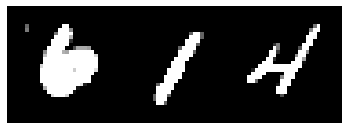

Computed value by the newtork (prediction) :  11


In [16]:
dataset_length = 1

MNISTSum = MNISTSummation(min_len=2, max_len=5, dataset_len=dataset_length, train=True, transform=MNIST_TRANSFORM)

x, target = MNISTSum.__getitem__(0)

print("Real value of the sum of digits (target) : ",target.item())
plt.imshow(torchvision.utils.make_grid(x, nrow=10).permute(1, 2, 0), cmap='gray')
plt.axis('off')
plt.show()

pred = the_experiment.test_after_training(x)
print("Computed value by the newtork (prediction) : ", pred)

Be wary that this value may not be correct and you may need to re-run the previous cell multiple times to obtain a "good" result... It really depends on how much we trained the model. 

But at last we have (almost) successfully built up our MNIST Digits summer. The results are 'usually' good and prove the utility of DeepSets. But is there a catch ? If you followed closely the theoritical part, you may already have noticed it... What about the case where the domain of our function $f$ is **continous** ? There appears the limitations of this method that we'll discuss in our final section.

## III - Limitations of DeepSets and the representation of functions on sets
Recall that we defined our backbone theorem as the following :
<div class="alert alert-success" style="margin-top: 1em">
    We denote by $\mathcal{P}(\mathfrak{X}) $ the power set of $\mathfrak{X}$, i.e the set of the sets of $\mathfrak{X}$.
    Let $f : \mathcal{P}(\mathfrak{X}) \rightarrow \mathbb{R}$ where $\mathfrak{X}$ is $\textbf{countable}$ (i.e, its cardinality is smaller or equal to the number of elements in $\mathbb{N}$. This includes both finite and countably infinite sets; e.g. $\mathbb{N}$, $\mathbb{Q}$, and subsets thereof). Then <b>$f$ is permutation-invariant if and only if it is sum-decomposable via the latent space $\mathbb{R}$</b>.
</div>
<br>
But what if the domain of our network (where the inputs "belong") is not countable? Said, $\mathbb{R}$? In fact, we do have a second theorem, albeit slightly less strong.

<div class="alert alert-success" style="margin-top: 1em">
    <b>Uncountable Case</b> :
    Let $M \in \mathbb{N}$, and let $f : [0, 1]^M \rightarrow \mathbb{R}$ be a continuous function. Then <b>$f$ is
    permutation-invariant if and only if it is continuously sum-decomposable via $\mathbb{R}^{M+1}$</b>
.
</div>
<br>

The proof is more complicated, we will not include it here (you can find it in the first paper refered). What this second theorem states is really interesting as it places a limit on the set size for a fixed finite-dimensional latent space. In particular, it shows that with a latent space of $M$ dimension is sufficient for representing all continuous permutation-invariant functions on sets of size $\leq M$. If you want to feed the model larger sets, there's no guarantee that it can represent your target function. This means that **if we want to use continuous mappings, the dimension of the latent space must be at least the maximum set size** . The details of this implications are nicely discussed in the answering paper of [Wagstaff et al., 2019](https://arxiv.org/abs/1901.09006). I encourage you to read it, especially the sections 3 and 4, as it discusses both the limitations of this method and the importance of continuity in neural networks !

## Conclusion

As a conclusion, we showed in this notebook a new take on neural networks, providing a great framework for building invariant models on sets. This method however suffers from limitations when working with more complex domains such as $\mathbb{R}$, and require attention when tuning the model. 
<br>
As further reading, I can recommend these articles : 
* [Lee et al., 2018](https://arxiv.org/abs/1810.00825), proposing an attention-based architecture to implement set functions, Set Transformer.
* [Bloem-Reddy and Teh, 2019](https://arxiv.org/abs/1901.06082) for a more theoretical take on invariances in neural networks.
* [Vartak et al., 2017](https://papers.nips.cc/paper/7266-a-meta-learning-perspective-on-cold-start-recommendations-for-items) developed a recommender system for Twitter using DeepSets. User's preferences are summarized by the set of tweets they recently engaged with on the platform. This set is processed by a DeepSets architecture, and the output of this set function is then fed into another neural network that scores new tweets the user might find interesting.
* [Maron et al., 2018](https://openreview.net/forum?id=Syx72jC9tm) for invariant and equivariant Graph Networks.

The implications for this topic are endless and will certainly develop even more in the future !

## Appendix : permutation equivariance

Permutation equivariance is another concept developed in the original paper by [Zaheer et al., 2017](https://arxiv.org/abs/1703.06114). Think of it as independance from permutation : if we take a function $f$ and a permutation $\pi$, $f$ is permutation equivariant if \begin{equation} f(\{x_1, ... , x_M\}) = \{f_{\pi(1)}(x), ... , f_{\pi(M)}(x)\} \end{equation}
<br>
This different concept is discussed in the original paper, albeit slightly less developed and applied. Up to you to implement it in Pytorch !